#import python packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D

#Read dataset as json file

In [2]:
with open("dataset/Intent.json") as diabetes_dataset:
  dataset = json.load(diabetes_dataset)

In [3]:
def processing_json_dataset(dataset):
  tags = []
  inputs = []
  responses={}
  for intent in dataset['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
      inputs.append(lines)
      tags.append(intent['intent'])
  return [tags, inputs, responses]

In [4]:
[tags, inputs, responses] = processing_json_dataset(dataset)

#dataset as DataFrame

In [5]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [6]:
dataset.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [7]:
dataset = dataset.sample(frac=1)

In [8]:
dataset.head()

,inputs,tags
114,Any gossip,Gossip
5,Hya,Greeting
62,That's helpful,Thanks
53,Do you know the time?,TimeQuery
137,Can you prove you are self aware,SelfAware


#Pre-processing text of dataset

In [9]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [10]:
dataset.head()

,inputs,tags
114,"[a, n, y, , g, o, s, s, i, p]",Gossip
5,"[h, y, a]",Greeting
62,"[t, h, a, t, s, , h, e, l, p, f, u, l]",Thanks
53,"[d, o, , y, o, u, , k, n, o, w, , t, h, e, ...",TimeQuery
137,"[c, a, n, , y, o, u, , p, r, o, v, e, , y, ...",SelfAware


In [11]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))

In [12]:
dataset.head()

,inputs,tags
114,any gossip,Gossip
5,hya,Greeting
62,thats helpful,Thanks
53,do you know the time,TimeQuery
137,can you prove you are self aware,SelfAware


In [13]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [14]:
len(features[0])

9

In [15]:
input_shape = features.shape[1]
print(input_shape)

9


In [16]:
features.shape

(143, 9)

In [17]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  117
output length:  22


In [18]:
tokenizer.word_index

{'you': 1,
 'me': 2,
 'is': 3,
 'are': 4,
 'i': 5,
 'what': 6,
 'the': 7,
 'do': 8,
 'can': 9,
 'thanks': 10,
 'name': 11,
 'am': 12,
 'please': 13,
 'your': 14,
 'pod': 15,
 'bay': 16,
 'door': 17,
 'tell': 18,
 'a': 19,
 'open': 20,
 'adam': 21,
 'bella': 22,
 'time': 23,
 'prove': 24,
 'not': 25,
 'real': 26,
 'to': 27,
 'gossip': 28,
 'how': 29,
 'why': 30,
 'talking': 31,
 'it': 32,
 'my': 33,
 'know': 34,
 'call': 35,
 'good': 36,
 'see': 37,
 'wasnt': 38,
 'goodbye': 39,
 'user': 40,
 'this': 41,
 'bye': 42,
 'who': 43,
 'thank': 44,
 'hello': 45,
 'very': 46,
 'great': 47,
 'any': 48,
 'hi': 49,
 'doing': 50,
 'well': 51,
 'clever': 52,
 'girl': 53,
 'will': 54,
 'for': 55,
 'ok': 56,
 'some': 57,
 'there': 58,
 'quiet': 59,
 'have': 60,
 'conscious': 61,
 'joke': 62,
 'hya': 63,
 'self': 64,
 'aware': 65,
 'whats': 66,
 'hope': 67,
 'hola': 68,
 'selfaware': 69,
 'saying': 70,
 'genious': 71,
 'anyone': 72,
 'in': 73,
 'camera': 74,
 'be': 75,
 'think': 76,
 'fuck': 77,
 'up':

#RNN MODEL

## Build RNN Model

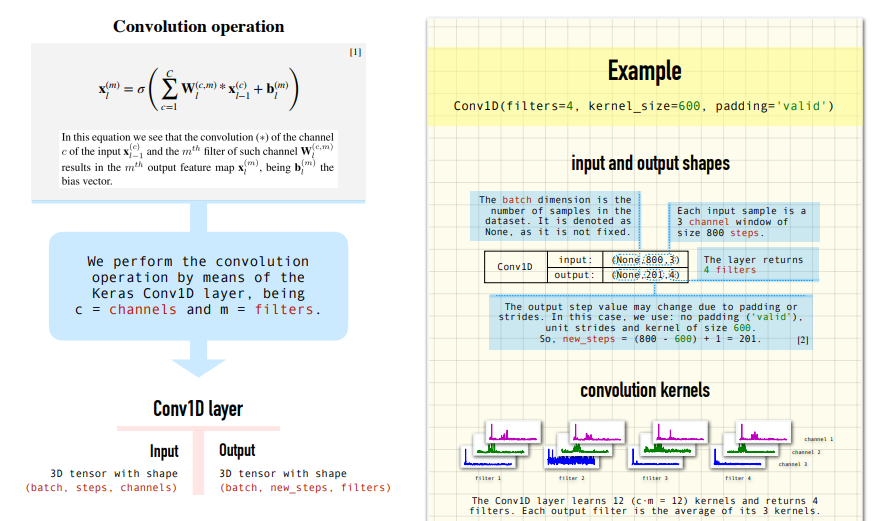

In [19]:
m = Sequential()
m.add(Input(shape=(features.shape[1],)))
m.add(Embedding(vocabulary + 1,100))
m.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.3))
m.add(LSTM(32, dropout=0.3,return_sequences=True))
m.add(LSTM(16, dropout=0.3,return_sequences=False))
m.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.6))
m.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [20]:
m.layers

[<Embedding name=embedding, built=True>,
 <Conv1D name=conv1d, built=True>,
 <Dropout name=dropout, built=True>,
 <LSTM name=lstm, built=True>,
 <LSTM name=lstm_1, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_1, built=True>]

In [22]:
glove_dir = "glove/glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding="utf8")
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [24]:
m.layers[0].set_weights([embedding_matrix])
m.layers[0].trainable = False

In [25]:
m.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [26]:
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 9, 100)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5, 32)          │        16,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,302 (173.05 KB)

 Trainable params: 32,502 (126.96 KB)

 Non-trainable params: 11,800 (46.09 KB)

In [27]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [28]:
history_training = m.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.0577 - loss: 3.2266
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0312 - loss: 3.1535
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0943 - loss: 3.1186 
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0814 - loss: 3.1068 
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1045 - loss: 3.0995 
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0425 - loss: 3.1001 
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0436 - loss: 3.0982 
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0604 - loss: 3.0964 
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0771 - loss: 3.0949 
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0390 - loss: 3.0954 
Epoch 11/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0830 - loss: 3.0951 
Epoch 12/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 

In [36]:
import matplotlib as mpl
def draw_plot(data, type_data):
  # mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

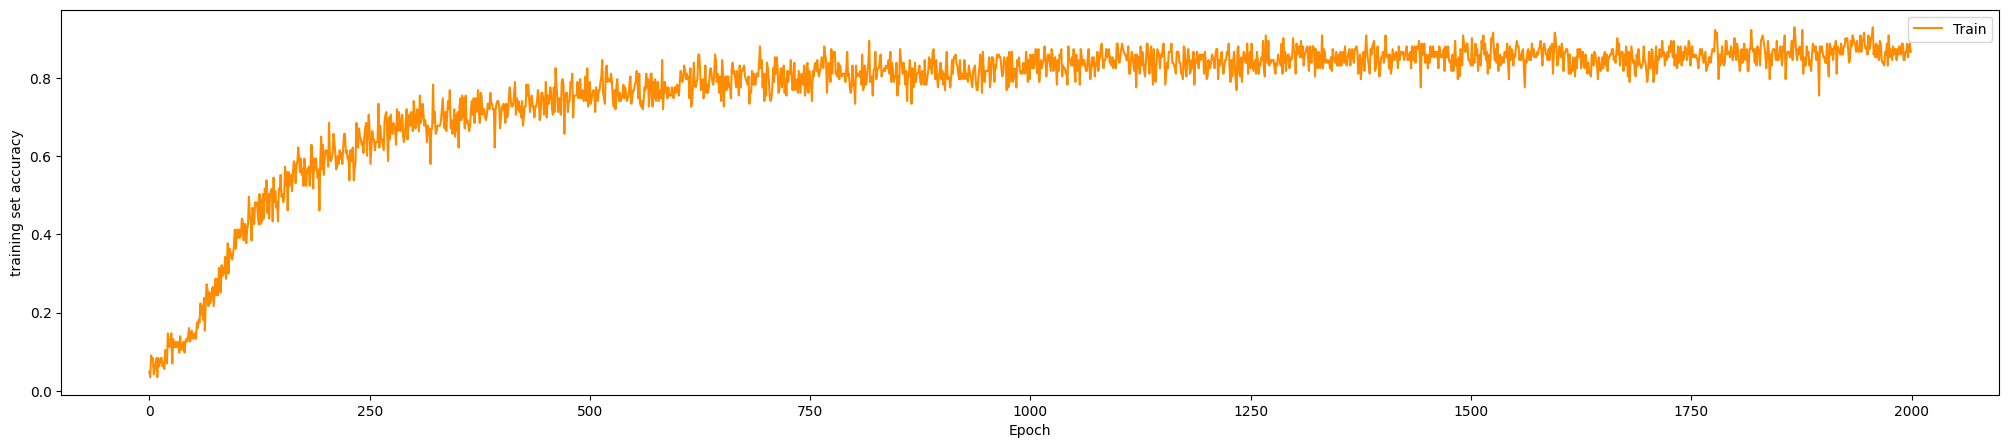

In [37]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

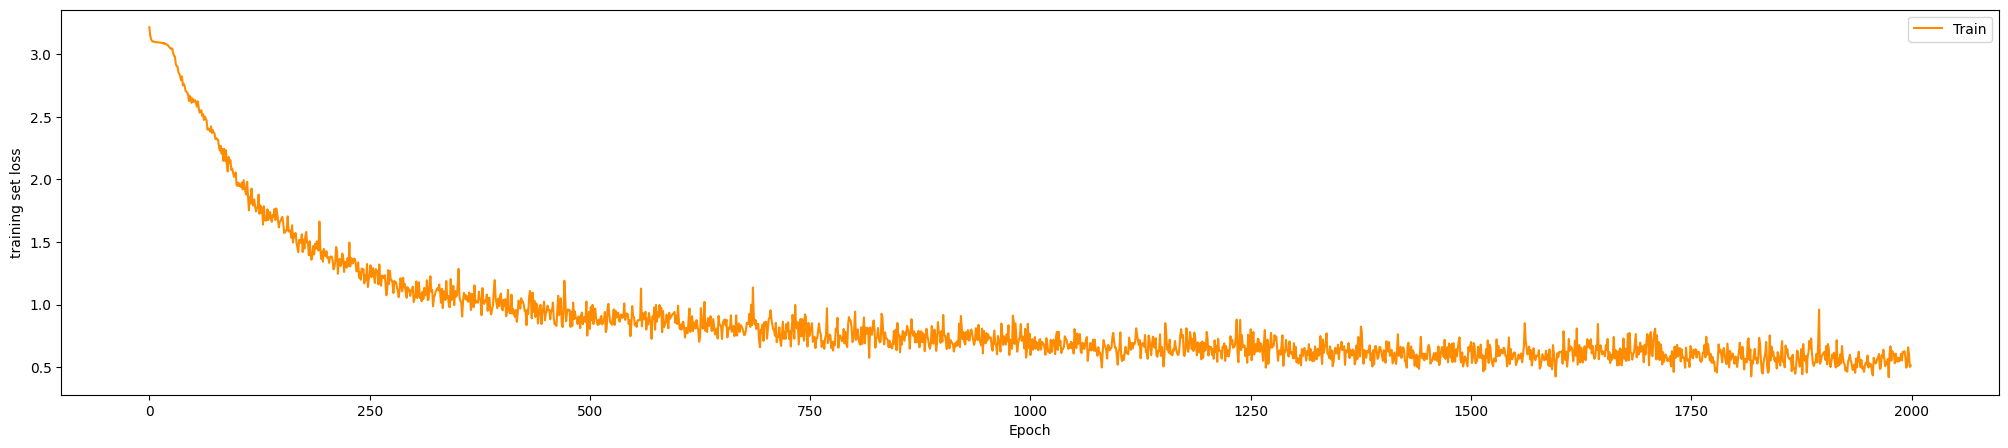

In [38]:
draw_plot(history_training.history['loss'],'training set loss' )

In [39]:
m.evaluate(features, labels, batch_size = 64)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9626 - loss: 0.2606  


[0.24278397858142853, 0.9720279574394226]

#Live Testing

In [40]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = m.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])

In [41]:
list_que = ["hello", "i am kaled","what is my name?",
            "what is your name?", "tell me please, what is your name?"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag)  

you: hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
Hello human, please tell me your GeniSys user
you: i am kaled
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
OK! Hola <HUMAN>, how can I help you?
you: what is my name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
<HUMAN>, what can I do for you?
you: what is your name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
You can call me Geni
you: tell me please, what is your name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Your name is <HUMAN>, how can I help you?
